# IBM Optimizations using Cirq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_compile_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_compile_css.ipynb)

Below is a brief tutorial on Superstaq optimizations for IBM Quantum superconducting qubit devices. For more information on IBM Quantum, visit their website [here](https://www.ibm.com/quantum).

## Imports and API Token

This example tutorial notebook uses `cirq-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install cirq-superstaq[examples]`:

In [1]:
# A specific version of qiskit is required. Force the version to be in the range v0.22 to v0.23.
try:
    import qiskit

    install_qiskit = not ("0.24" < qiskit.__version__ < "0.25")
except ImportError:
    install_qiskit = True

if install_qiskit:
    print("Installing qiskit...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed qiskit.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit

Installing qiskit...
Note: you may need to restart the kernel to use updated packages.
Installed qiskit.
You may need to restart the kernel to import newly installed packages.


In [2]:
try:
    import cirq
    import cirq_superstaq as css
except ImportError:
    print("Installing cirq-superstaq...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed cirq-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import cirq
    import cirq_superstaq as css

import numpy as np

To interface Superstaq via Cirq, we must first instantiate a service with `cirq_superstaq.Service()`. We then supply a Superstaq API token by either providing the API token as an argument to `cirq_superstaq.Service()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_css.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [3]:
# Provide your Superstaq API key using the "api_key" argument
service = css.Service()

## Single Circuit Compilation

Let us start by creating an example Cirq circuit that we will then compile and optimize for the 127-qubit IBM Quantum `brisbane` processor.

In [4]:
# Create a two-qubit cirq circuit
qubits = cirq.LineQubit.range(2)
theta = np.random.uniform(0, 4 * np.pi)
circuit = cirq.Circuit(
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.Rz(rads=theta)(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.measure(qubits[0], qubits[1]),
)

# Visualize circuit
circuit

0: ───@────────────────@───M───
      │                │   │
1: ───X───Rz(-1.28π)───X───M───

We will now compile the above circuit to IBM's `brisbane` processor and visualize the differences by drawing the compiled circuit. 

In [5]:
# Compile with qscout compile
compiler_output = service.ibmq_compile(circuit, target="ibmq_brisbane_qpu")

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit

0: ───Rz(π)───X^0.5──────Rz(0.5π)───AceCR+-(Z side)───X^0.5───Rz(1.72π)───X^0.5───AceCR+-(Z side)───Rz(0.5π)───X^0.5───M───
                                    │                                             │                                    │
1: ───X^0.5───Rz(1.5π)──────────────AceCR+-(X side)───Rz(π)───────────────────────AceCR+-(X side)───Rz(0.5π)───X^0.5───M───

The resulting output is now a circuit compiled to `brisbane`'s native operations. With Superstaq compilation, you can also get the corresponding Qiskit Pulse schedule (see [Qiskit Pulse documentation](https://qiskit.org/documentation/apidoc/pulse.html) and [original paper](https://arxiv.org/abs/2004.06755)) for the compiled circuit by running the following:

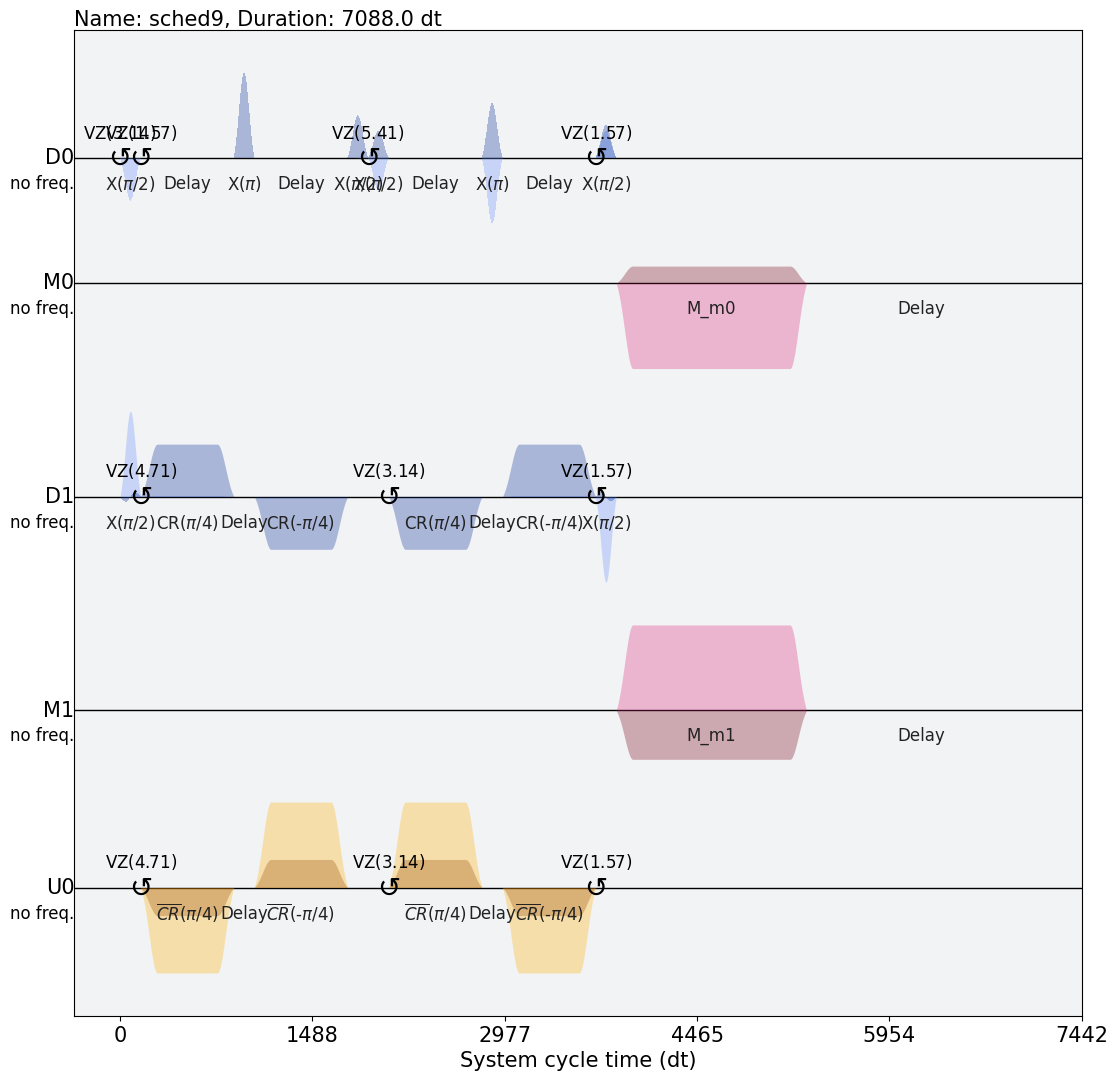

In [6]:
# Visualize the pulse schedule using Qiskit Pulse
compiler_output.pulse_sequence.draw()

## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple-circuit input as well. To illustrate this, let us create a different example two-qubit circuit: a Bell-state circuit.

In [7]:
# Create second circuit
bell_circuit = cirq.Circuit(
    cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.measure(qubits[0], qubits[1])
)

# Visualize second circuit
bell_circuit

0: ───H───@───M───
          │   │
1: ───────X───M───

By passing multiple circuits as a list to the `ibmq_compile` endpoint, we can compile all of them individually with a single call to the endpoint. This will return all the corresponding compiled circuits and pulse schedules back as a list, like so:  

In [8]:
# Create list of circuits
circuit_list = [circuit, bell_circuit]

# Compile list of circuits
compiler_output_list = service.ibmq_compile(circuit_list, "ibmq_brisbane_qpu")

# The list of compiled output circuits is stored in the `circuits` attribute instead of `circuit`. Likewise for
# pulse sequences.
output_circuits = compiler_output_list.circuits
output_pulse_sequences = compiler_output_list.pulse_sequences

In [9]:
# Visualize the first compiled circuit
print("Compiled circuit 1 \n")
output_circuits[0]

Compiled circuit 1 



0: ───Rz(π)───X^0.5──────Rz(0.5π)───AceCR+-(Z side)───X^0.5───Rz(1.72π)───X^0.5───AceCR+-(Z side)───Rz(0.5π)───X^0.5───M───
                                    │                                             │                                    │
1: ───X^0.5───Rz(1.5π)──────────────AceCR+-(X side)───Rz(π)───────────────────────AceCR+-(X side)───Rz(0.5π)───X^0.5───M───

In [10]:
circuit = cirq.Circuit(css.AceCR("-+", np.pi / 2)(qubits[0], qubits[1]))
out = service.ibmq_compile(circuit, target="ibmq_brisbane_qpu")

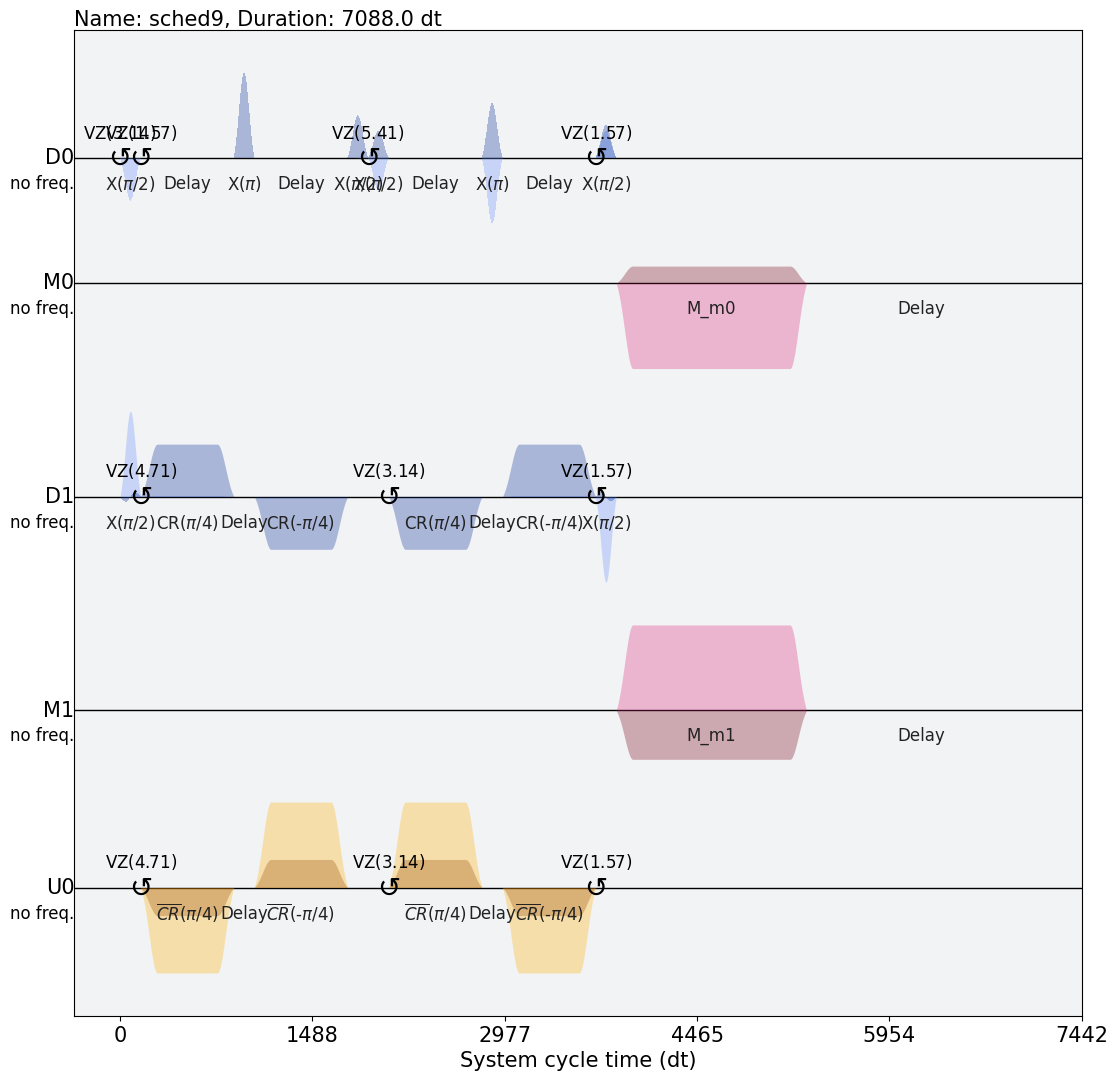

In [11]:
# Visualize the pulse sequence for the first compiled circuit
output_pulse_sequences[0].draw()

In [12]:
# Visualize the second compiled circuit
print("Compiled circuit 2 \n")
output_circuits[1]

Compiled circuit 2 



0: ───Rz(1.5π)───X^0.5───AceCR+-(Z side)───M───
                         │                 │
1: ───X^0.5──────────────AceCR+-(X side)───M───

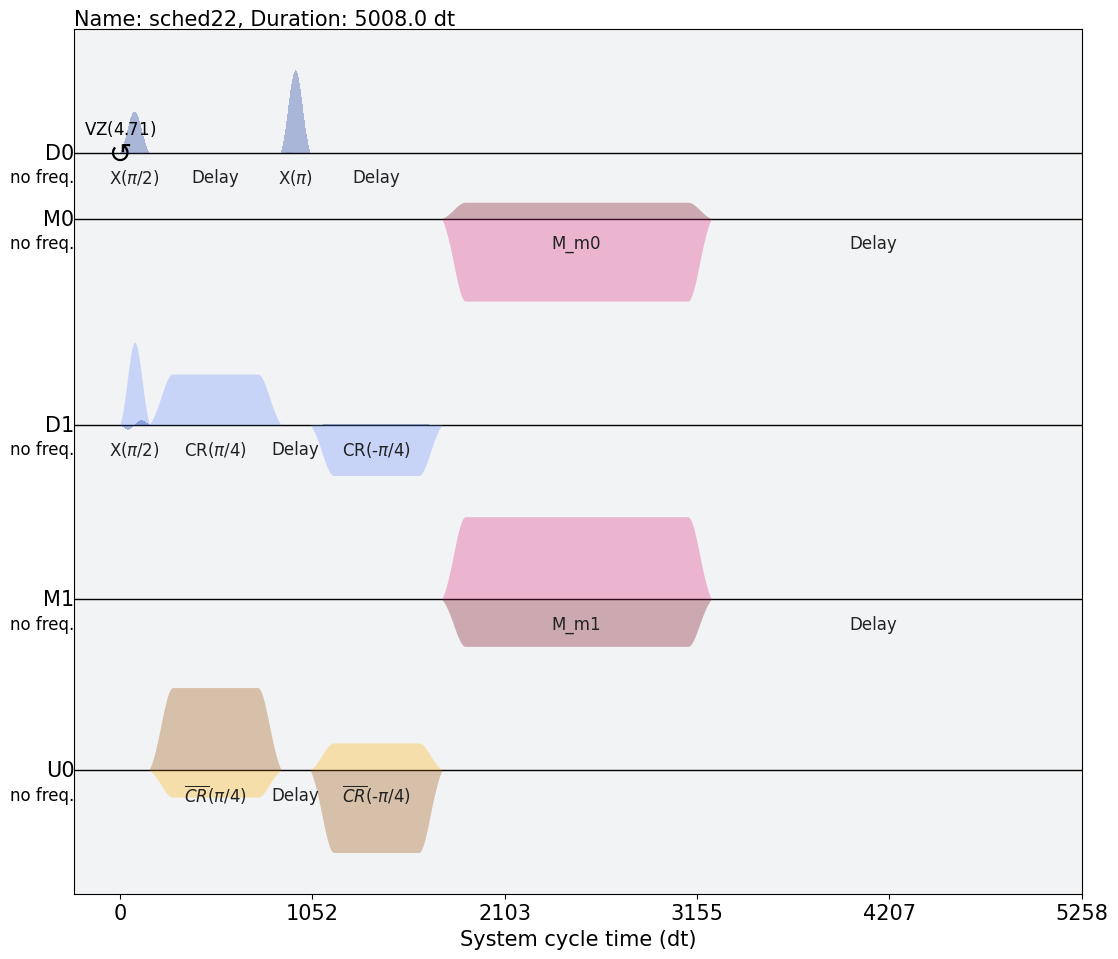

In [13]:
# Visualize the pulse sequence for the second compiled circuit
output_pulse_sequences[1].draw()

## Using Superstaq Simulator

Lastly, we will show (a) how to submit a circuit to a backend and (b) how to simulate circuit execution. Simulation is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `create_job()` on the Superstaq service.

In [14]:
# Create job that submits to IBM Quantum backend
job = service.create_job(
    bell_circuit,
    repetitions=1000,
    target="ibmq_brisbane_qpu",
    method="dry-run",  # Specify "dry-run" as the method to run Superstaq simulation
)

# Get the counts from the measurement
print(job.counts(0))

{'00': 480, '11': 520}
